In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()

import dense_correspondence
from dense_correspondence.evaluation.evaluation import *
import dense_correspondence.correspondence_tools.correspondence_plotter as correspondence_plotter
from dense_correspondence.dataset.dense_correspondence_dataset_masked import ImageType

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Using SpartanDataset:
   - in train mode
   - number of scenes 11
   - total images:     2851


-----------Train Data Evaluation----------------
Image pair (233, 1836)


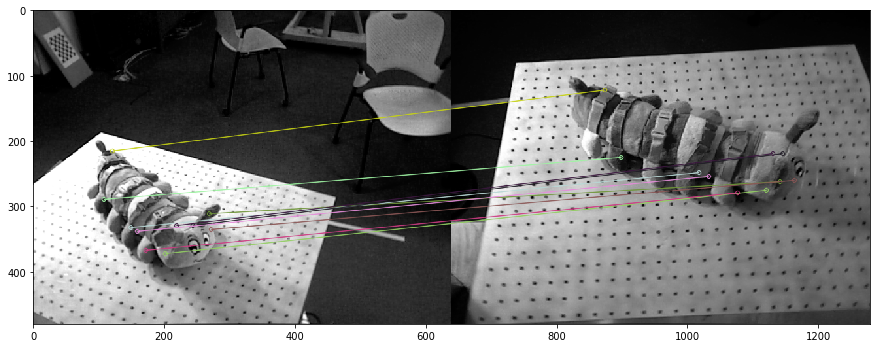

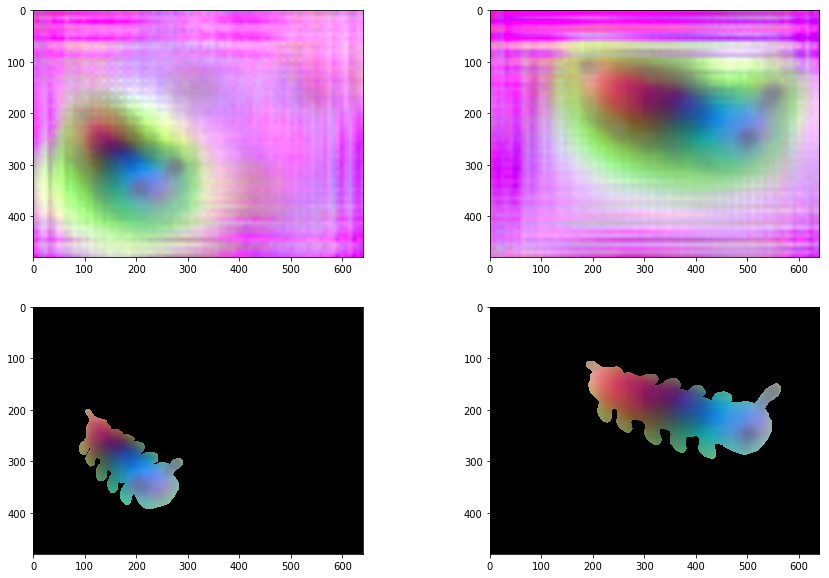

Image pair (227, 1152)


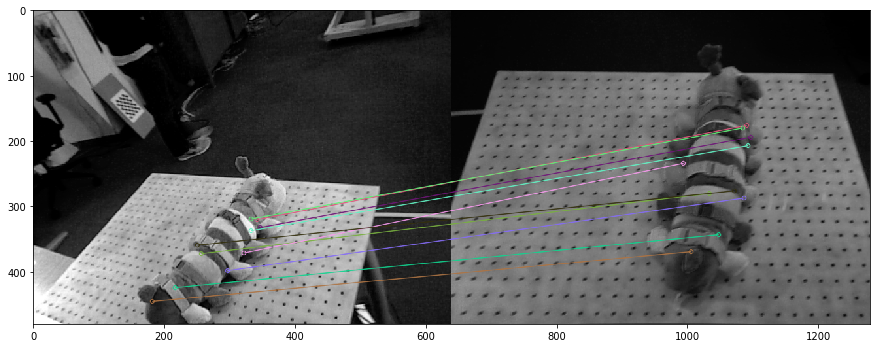

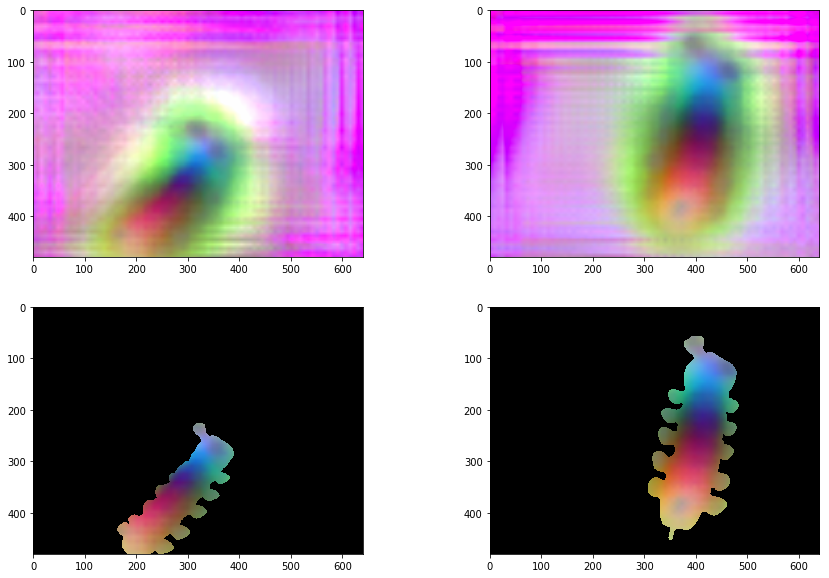

Image pair (435, 595)


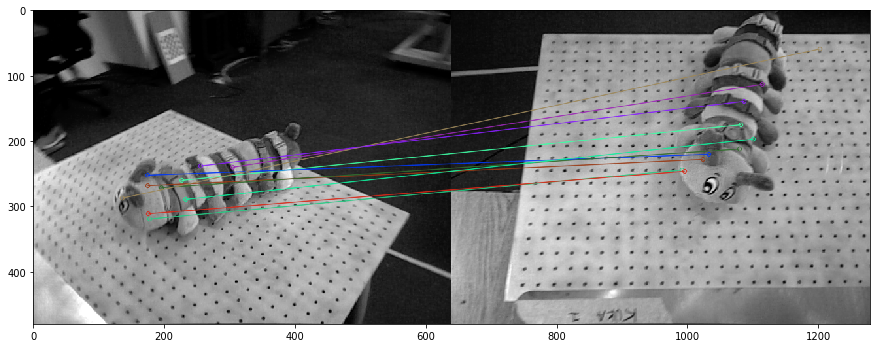

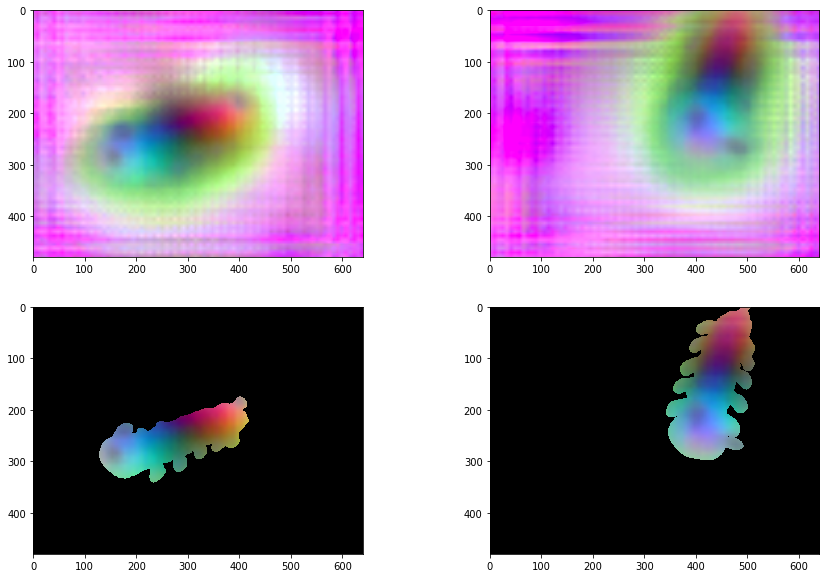

Image pair (1404, 1128)


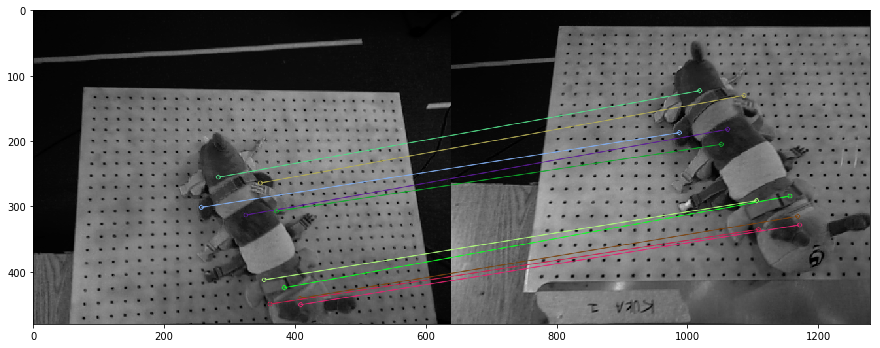

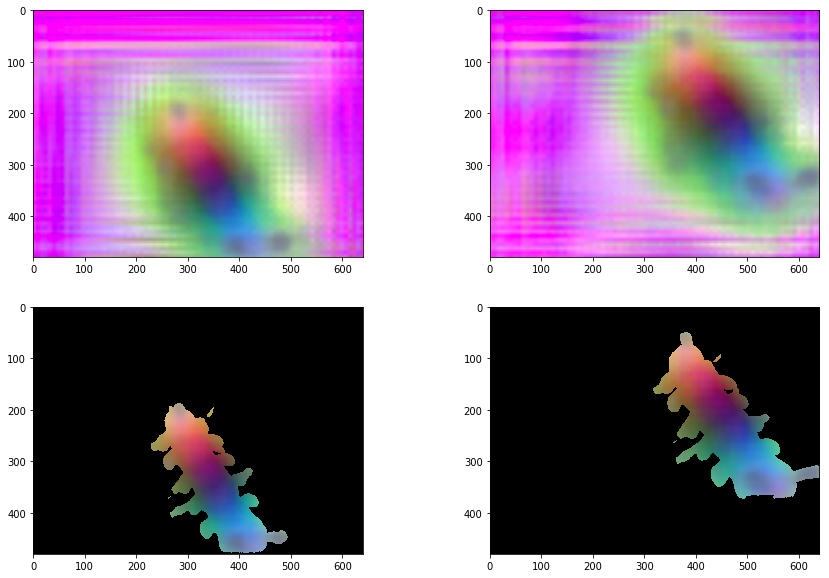

Image pair (835, 1594)


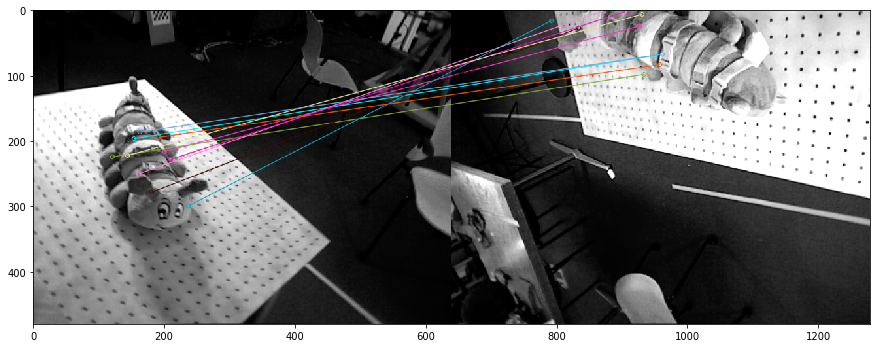

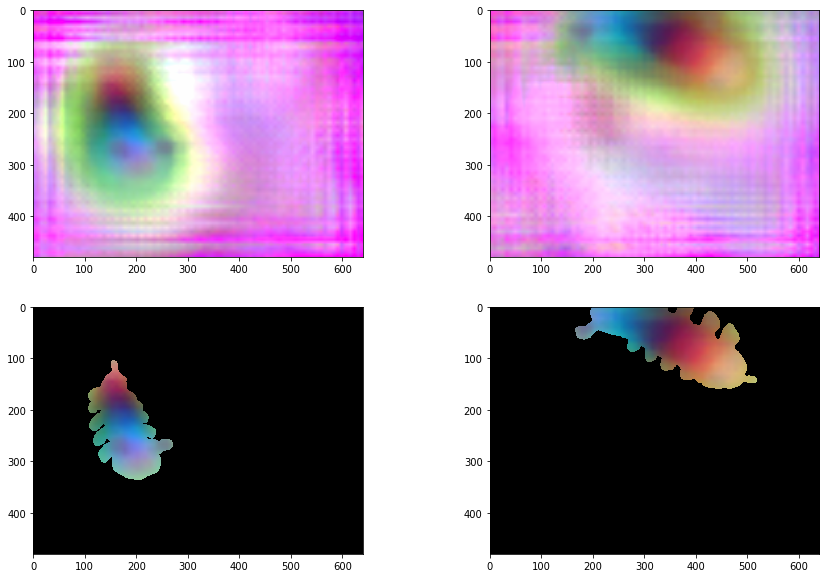



-----------Test Data Evaluation----------------
Image pair (2181, 2439)


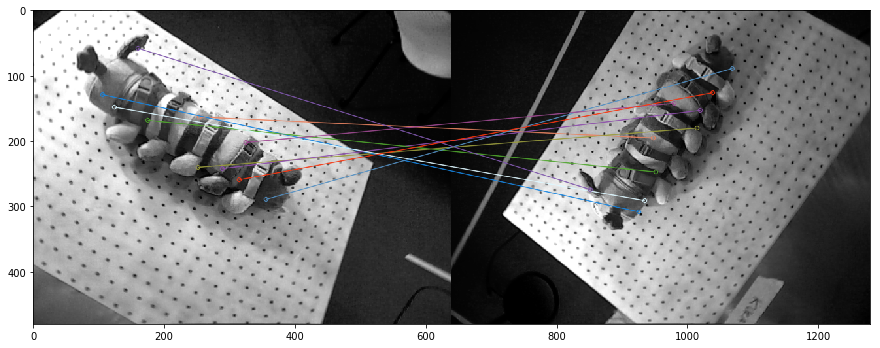

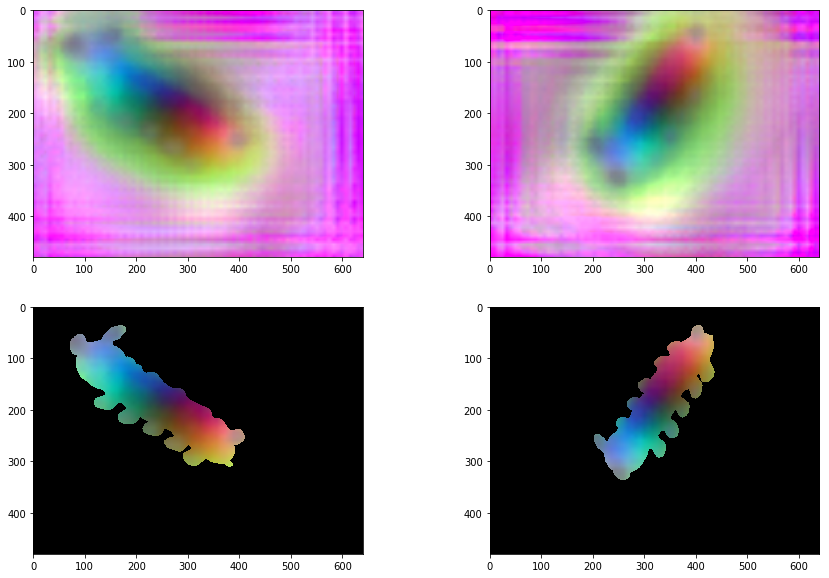

Image pair (1009, 1545)


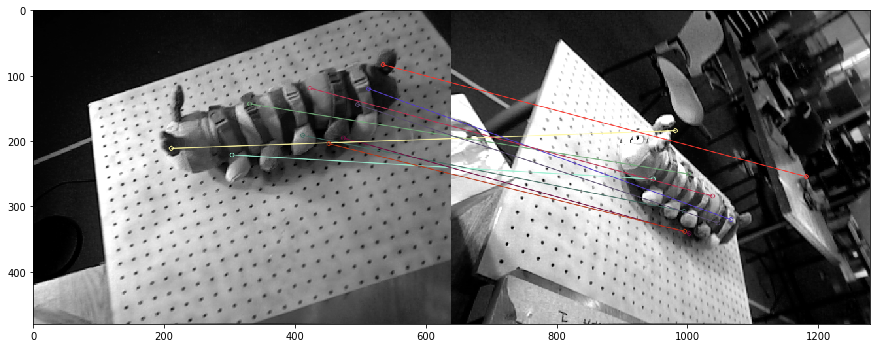

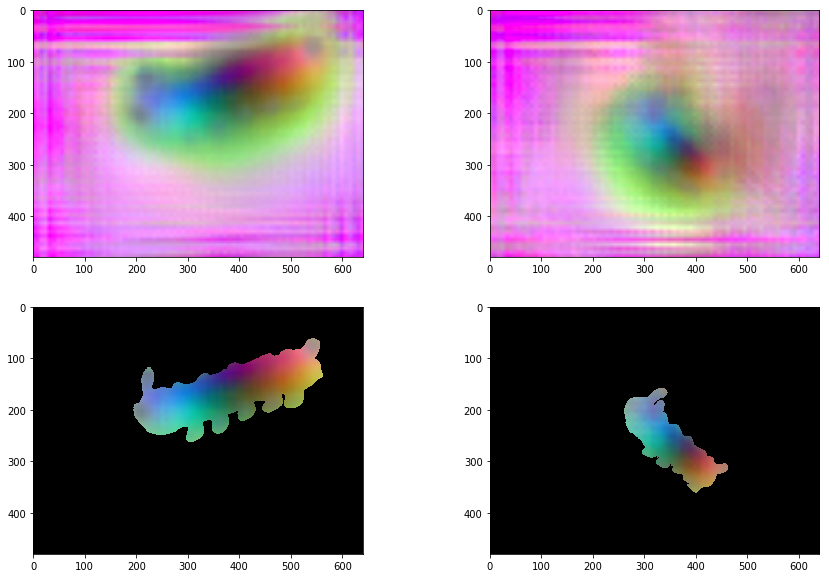

Image pair (2066, 630)


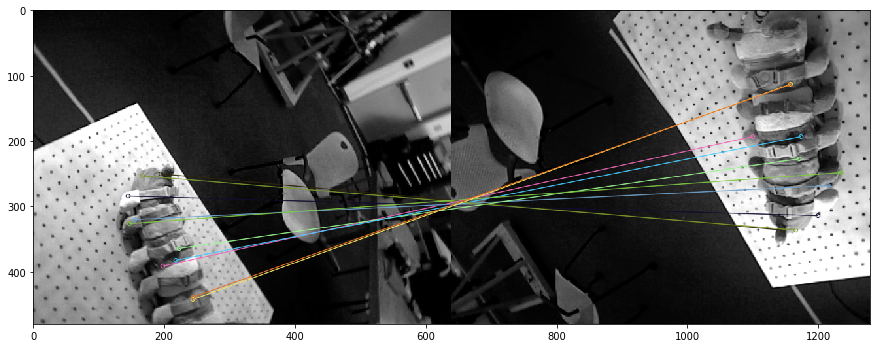

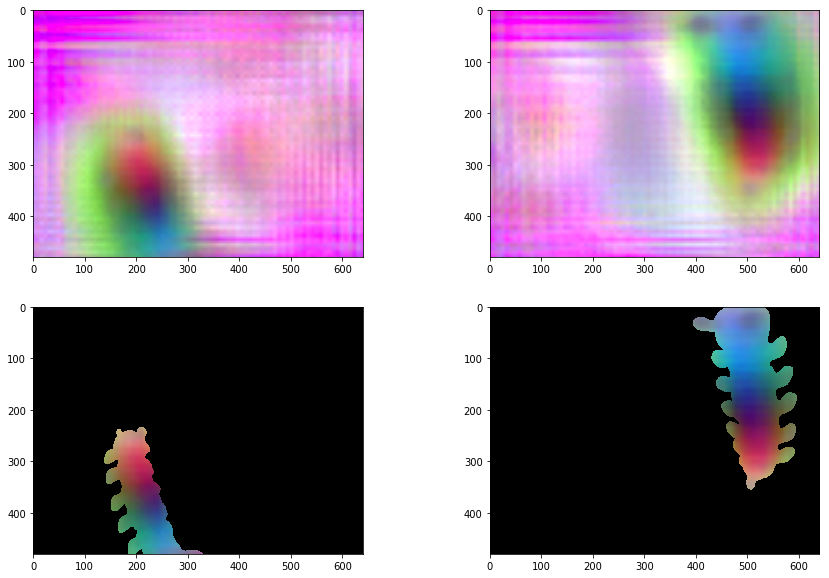

Image pair (2514, 2191)


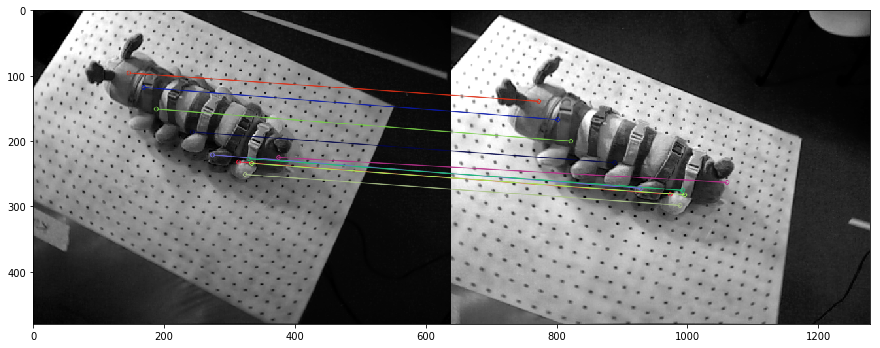

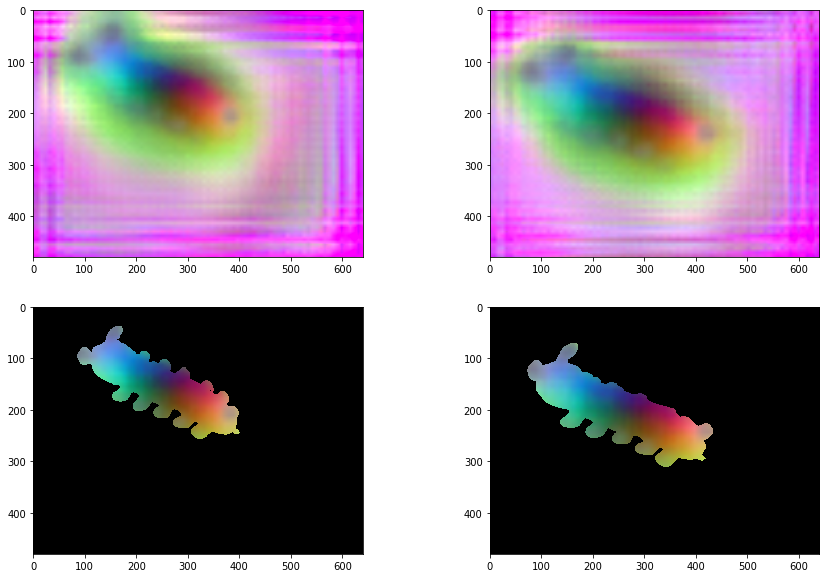

Image pair (592, 801)


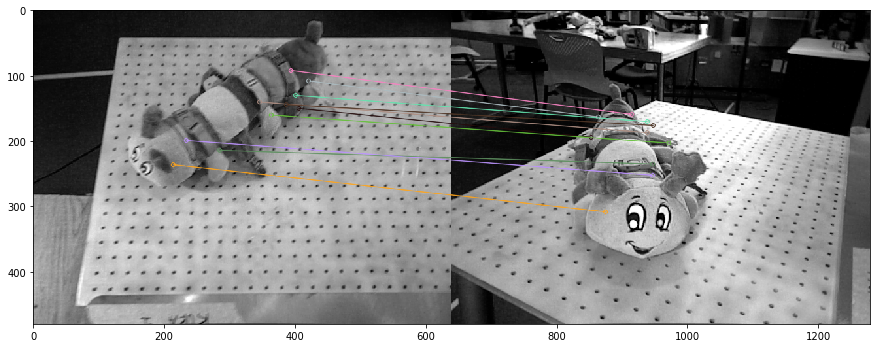

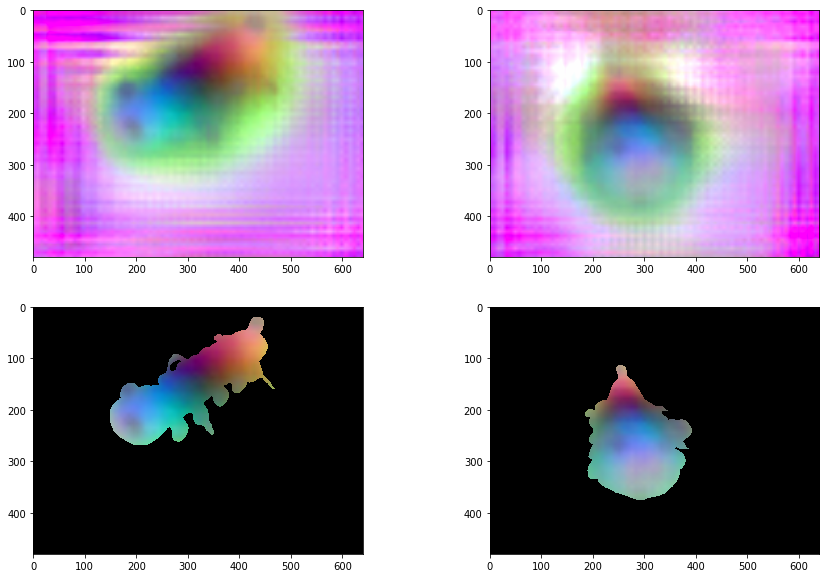

In [9]:
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 
                               'dense_correspondence', 'evaluation', 'evaluation.yaml')
config = utils.getDictFromYamlFilename(config_filename)
default_config = utils.get_defaults_config()

# utils.set_cuda_visible_devices([0])
dce = DenseCorrespondenceEvaluation(config)
DCE = DenseCorrespondenceEvaluation

network_name = "caterpillar_3"
dcn = dce.load_network_from_config(network_name)
dataset = dcn.load_training_dataset()
DenseCorrespondenceEvaluation.evaluate_network_qualitative(dcn, dataset=dataset, randomize=True)

In [18]:
dataset_config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence',
                                       'dataset', 'composite',
                                       'caterpillar_upright.yaml')
# dataset_config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence',
#                                        'training', 'training.yaml')
dataset_config = utils.getDictFromYamlFilename(dataset_config_filename)

dataset = SpartanDataset(debug=True, config=dataset_config)

Using SpartanDataset:
   - in train mode
   - number of scenes 11
   - total images:     2851


In [15]:
dataset_config

{'logs_root_path': 'logs_proto',
 'multi_object_scenes_config_files': [],
 'single_object_scenes_config_files': ['caterpillar_upright.yaml']}

In [19]:
# dataset.set_parameters_from_training_config(dataset_config)
dataset.debug=False

In [20]:
data = dataset.get_single_object_within_scene_data()
match_type, image_a_rgb, image_b_rgb, \
matches_a, matches_b, masked_non_matches_a, \
masked_non_matches_a, non_masked_non_matches_a, \
non_masked_non_matches_b, blind_non_matches_a, \
blind_non_matches_b, metadata = data

In [21]:
metadata

{'image_a_idx': 840,
 'image_b_idx': 593,
 'object_id': 'caterpillar',
 'object_id_int': 0,
 'scene_name': '2018-04-10-16-13-37',
 'type': 0}

In [24]:
DenseCorrespondenceEvaluation.single_image_pair_sift_analysis(dataset,metadata['scene_name'],metadata['image_a_idx'],metadata['image_b_idx'])

SystemError: error return without exception set

In [104]:
def get_relative_pose(dataset,metadata):
    X_OCa = dataset.get_pose_from_scene_name_and_idx(metadata['scene_name'], metadata['image_a_idx'])
    X_OCb = dataset.get_pose_from_scene_name_and_idx(metadata['scene_name'], metadata['image_b_idx'])
    X_CbCa = np.matmul(np.linalg.inv(X_OCb), X_OCa)
    return X_CbCa

In [131]:
import yaml
def get_intrinsic(dataset, metadata):
    scene_directory = dataset.get_full_path_for_scene(metadata['scene_name'])
    yaml_filename = images_dir = os.path.join(scene_directory, 'images','camera_info.yaml')
    config = yaml.load(open(yaml_filename), Loader=yaml.CLoader)
    
    fx = config['camera_matrix']['data'][0]
    cx = config['camera_matrix']['data'][2]

    fy = config['camera_matrix']['data'][4]
    cy = config['camera_matrix']['data'][5]
    K = np.array([[fx, 0, cx], [0, fy, cy], [0,0,1]])
    
    dist_coeffs = np.array(config['distortion_coefficients']['data'][:])
    return K, dist_coeffs
K, dist_coeffs = get_intrinsic(dataset, metadata)

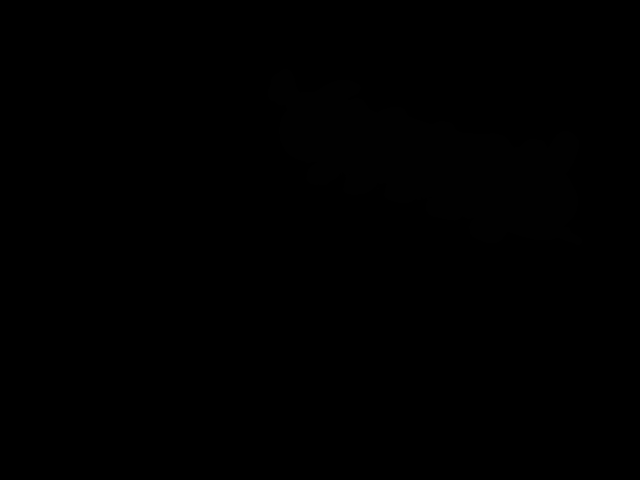

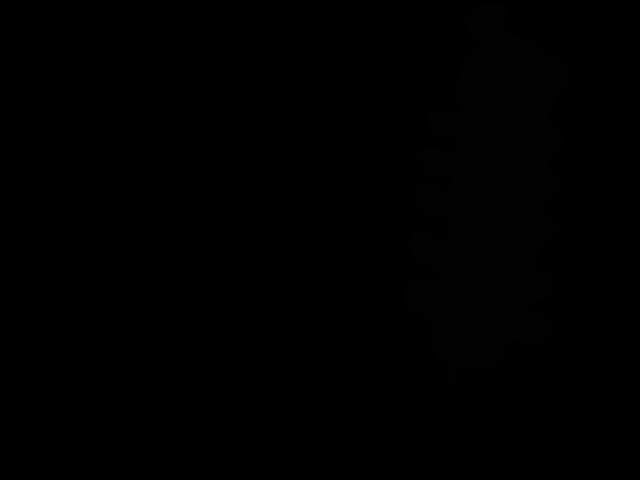

In [28]:
# img_filename = dataset.get_image_filename(metadata['scene_name'], metadata['image_a_idx'], 0)
# image_a = dataset.get_rgb_image(img_filename)
# img_filename = dataset.get_image_filename(metadata['scene_name'], metadata['image_b_idx'], 0)
# image_b = dataset.get_rgb_image(img_filename)
image_a, _, mask_a, pose_a = dataset.get_rgbd_mask_pose(metadata['scene_name'], metadata['image_a_idx'])
image_b, _, mask_b, pose_b = dataset.get_rgbd_mask_pose(metadata['scene_name'], metadata['image_b_idx'])
display(mask_a)
display(mask_b)

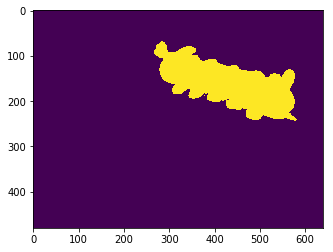

In [31]:
plt.imshow(np.array(mask_a))

In [340]:
np.array(mask_a).sum()/float(np.array(mask_a).shape[0]*np.array(mask_a).shape[1])

0.09031901041666666

In [341]:
np.array(mask_a).max()

1

In [308]:
def get_matches(dcn, dataset, rgb_a, rgb_b, mask_a, mask_b,num_matches):
    mask_a = np.asarray(mask_a)
    mask_b = np.asarray(mask_b)

    # compute dense descriptors
    rgb_a_tensor = dataset.rgb_image_to_tensor(rgb_a)
    rgb_b_tensor = dataset.rgb_image_to_tensor(rgb_b)

    # these are Variables holding torch.FloatTensors, first grab the data, then convert to numpy
    res_a = dcn.forward_single_image_tensor(rgb_a_tensor).data.cpu().numpy()
    res_b = dcn.forward_single_image_tensor(rgb_b_tensor).data.cpu().numpy()


    # sample points on img_a. Compute best matches on img_b
    # note that this is in (x,y) format
    # TODO: if this mask is empty, this function will not be happy
    # de-prioritizing since this is only for qualitative evaluation plots
    sampled_idx_list = random_sample_from_masked_image(mask_a, num_matches)

    # list of cv2.KeyPoint
    kp1 = []
    kp2 = []
    matches = []  # list of cv2.DMatch
    diffs = []

    # placeholder constants for opencv
    diam = 0.01
    dist = 0.01

    try:
        descriptor_image_stats = dcn.descriptor_image_stats
    except:
        print "Could not find descriptor image stats..."
        print "Only normalizing pairs of images!"
        descriptor_image_stats = None

    for i in xrange(0, num_matches):
        # convert to (u,v) format
        pixel_a = [sampled_idx_list[1][i], sampled_idx_list[0][i]]
        best_match_uv, best_match_diff, norm_diffs =\
            DenseCorrespondenceNetwork.find_best_match(pixel_a, res_a,res_b)

        # be careful, OpenCV format is  (u,v) = (right, down)
        kp1.append(cv2.KeyPoint(pixel_a[0], pixel_a[1], diam))
        kp2.append(cv2.KeyPoint(best_match_uv[0], best_match_uv[1], diam))
        diffs.append(best_match_diff)
        matches.append(cv2.DMatch(i, i, dist))
    return kp1,kp2, matches, diffs
kp1,kp2, matches,diffs = get_matches(dcn, dataset, image_a,image_b, mask_a,mask_b,100)

kp1_array = np.array([kp1[idx].pt for idx in range(len(kp1))]).reshape(-1, 1,2)
kp2_array = np.array([kp2[idx].pt for idx in range(len(kp2))]).reshape(-1,1, 2)
pts_1_norm = cv2.undistortPoints(kp1_array, cameraMatrix=K, distCoeffs=dist_coeffs)
pts_2_norm = cv2.undistortPoints(kp2_array, cameraMatrix=K, distCoeffs=dist_coeffs)
# E, mask = cv2.findEssentialMat(kp1_array, kp2_array, method=cv2.RANSAC, threshold=3)
# E, mask = cv2.findEssentialMat(pts_1_norm, pts_2_norm,cameraMatrix=K, method=cv2.RANSAC, threshold=2/K[0][0])
# _, R_est, t_est, mask2 = cv2.recoverPose(E, kp1_array, kp2_array, K, mask=mask)

# X_real = get_relative_pose(dataset, metadata)
# # X_real = np.linalg.inv(X_real)
# R_real = X_real[:3,:3]
# t_real = X_real[:3,3]
# R_real,t_real
# print(np.matmul(R_est, np.linalg.inv(R_real)))
# print(t_real/np.linalg.norm(t_real), t_est.reshape(-1))

In [294]:
K, dist_coeffs = get_intrinsic(dataset, metadata)
K

array([[533.6422696 ,   0.        , 319.40910308],
       [  0.        , 534.78244452, 236.43742997],
       [  0.        ,   0.        ,   1.        ]])

In [298]:
pp = K[:2,2]
focal_length = (K[0][0]+K[1][1])/2
print pp,focal_length
F, mask = cv2.findFundamentalMat(kp1_array, kp2_array, method=cv2.FM_RANSAC)
E = np.matmul(K.T, np.matmul(F, K))
xxx, R_est, t_est, mask2 = cv2.recoverPose(E, kp1_array, kp2_array, cameraMatrix=K, mask=mask)
X_real = get_relative_pose(dataset, metadata)
# X_real = np.linalg.inv(X_real)
R_real = X_real[:3,:3]
t_real = X_real[:3,3]
R_real,t_real
print(np.matmul(R_est, np.linalg.inv(R_real)))
print(t_real/np.linalg.norm(t_real), t_est.reshape(-1))

[319.40910308 236.43742997] 534.2123570634203
[[ 0.7279683  -0.12454148 -0.6742044 ]
 [ 0.03284621  0.98856917 -0.14714658]
 [ 0.68482354  0.08497298  0.72373774]]
(array([-0.85252212, -0.05521333,  0.51976679]), array([ 0.20405247, -0.2171198 ,  0.95457927]))


In [331]:
# E, mask = cv2.findEssentialMat(kp1_array, kp2_array, method=cv2.RANSAC, threshold=3)
E, mask = cv2.findEssentialMat(pts_1_norm, pts_2_norm,focal=focal_length,pp=tuple(pp), method=cv2.RANSAC, threshold=2)

xxx, R_est, t_est, mask2 = cv2.recoverPose(E, kp1_array, kp2_array, focal=focal_length,pp=tuple(pp), mask=mask)
# print xxx

X_real = get_relative_pose(dataset, metadata)
# X_real = np.linalg.inv(X_real)
R_real = X_real[:3,:3]
t_real = X_real[:3,3]
R_real,t_real
print(np.matmul(R_est, np.linalg.inv(R_real)))
print(t_real/np.linalg.norm(t_real), t_est.reshape(-1))
# np.matmul(R_est, R_real)

[[ 0.99180104  0.12721804 -0.0120938 ]
 [ 0.09854115 -0.82160926 -0.56146939]
 [-0.08136541  0.55567419 -0.82740913]]
(array([-0.85252212, -0.05521333,  0.51976679]), array([-0.47932407, -0.35503196,  0.80262117]))


In [337]:
def cal_error(dataset, metadata, R_est, t_est):
    X_real = get_relative_pose(dataset, metadata)
    # X_real = np.linalg.inv(X_real)
    R_real = X_real[:3,:3]

    trans = np.diag([1,-1,-1])
    R_real = np.matmul(trans, R_real)
    t_real = X_real[:3,3]
    dR = np.matmul(R_est, np.linalg.inv(R_real))
    print(dR)
    dtheta = np.arccos((np.trace(dR)-1)/2)
    print(dtheta)
    print(t_real/np.linalg.norm(t_real), t_est.reshape(-1))
cal_error(dataset, metadata, R_est, t_est)

[[ 0.99180104 -0.12721804  0.0120938 ]
 [ 0.09854115  0.82160926  0.56146939]
 [-0.08136541 -0.55567419  0.82740913]]
0.6086691105844304
(array([-0.85252212, -0.05521333,  0.51976679]), array([-0.47932407, -0.35503196,  0.80262117]))


In [330]:
def epipolar_constraint(R,t,kp1, kp2, mask):
    t=t.reshape(-1)
    #     print t
    t_x = np.array([[0, -t[2],t[1]],[t[2],0,-t[0]],[-t[1],t[0],0]])
    #     print t_x
    #     print R
    E =np.dot(t_x,R)
    
    kp1_array = np.array([kp1[idx].pt for idx in range(len(kp1))]).reshape(-1, 1,2)
    kp2_array = np.array([kp2[idx].pt for idx in range(len(kp2))]).reshape(-1,1, 2)
    pts_1_norm = cv2.undistortPoints(kp1_array, cameraMatrix=K, distCoeffs=dist_coeffs)
    pts_2_norm = cv2.undistortPoints(kp2_array, cameraMatrix=K, distCoeffs=dist_coeffs)
    
#     kp1_array = np.array([kp1[idx].pt for idx in range(len(kp1))]).reshape(-1, 2)
#     kp2_array = np.array([kp2[idx].pt for idx in range(len(kp2))]).reshape(-1, 2)

    # kp1_array = np.hstack([kp1_array, np.ones(kp1_array.shape[0],1)])
    # kp2_array = np.hstack([kp2_array, np.ones(kp1_array.shape[0],1)])
    mat_e = E.reshape(-1,1)
    u1 = pts_1_norm[:,0,0]
    u2 = pts_1_norm[:,0,1]
    v1 = pts_2_norm[:,0,0]
    v2 = pts_2_norm[:,0,1]

    A = np.stack([u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2,np.ones_like(u1)]).T
    print A.shape
    error = np.matmul(A,mat_e)
    print error
    # error = np.matmul(kp1_array, E, kp2_array.T)

    return error.sum()
epipolar_constraint(R_est, t_est, kp1,kp2,mask)

(100, 9)
[[0.50454281]
 [0.24930683]
 [0.42610107]
 [0.6145171 ]
 [0.46003531]
 [0.68429486]
 [0.5065086 ]
 [0.5644237 ]
 [0.31656436]
 [0.69850253]
 [0.51222705]
 [0.28087126]
 [0.31595141]
 [0.26727211]
 [0.33541708]
 [0.66457238]
 [0.30063247]
 [0.24796341]
 [0.56462096]
 [0.39077955]
 [0.49876448]
 [0.33480674]
 [0.3642926 ]
 [0.39112986]
 [0.6033423 ]
 [0.26231314]
 [0.36252238]
 [0.58899151]
 [0.31565293]
 [0.65852197]
 [0.45678291]
 [0.63820276]
 [0.39790443]
 [0.54602069]
 [0.54922071]
 [0.30367307]
 [0.27956704]
 [0.26088832]
 [0.54275217]
 [0.26789981]
 [0.6113968 ]
 [0.64395432]
 [0.38312602]
 [0.59273326]
 [0.40648717]
 [0.34234406]
 [0.48944994]
 [0.41083616]
 [0.6052947 ]
 [0.53534409]
 [0.27851064]
 [0.24337946]
 [0.54233003]
 [0.3039491 ]
 [0.32247496]
 [0.2492826 ]
 [0.58302742]
 [0.47410601]
 [0.5252113 ]
 [0.53176218]
 [0.59832454]
 [0.27836436]
 [0.20661698]
 [0.40279976]
 [0.34352587]
 [0.64277219]
 [0.68140594]
 [0.43681226]
 [0.51822026]
 [0.59111463]
 [0.4924792

43.81943977023365

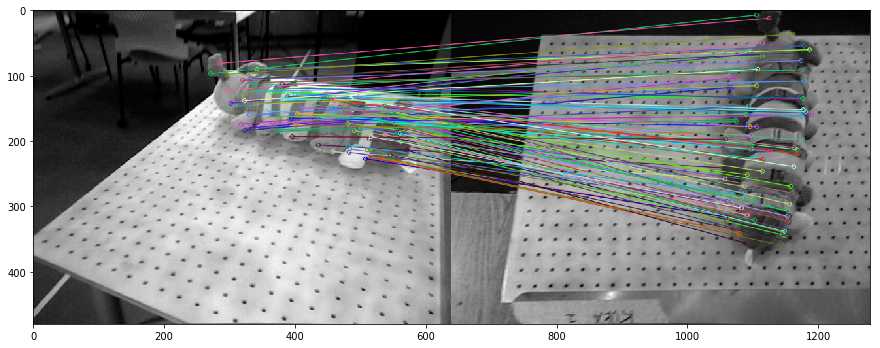

In [342]:
gray_a_numpy = cv2.cvtColor(np.asarray(image_a), cv2.COLOR_BGR2GRAY)
gray_b_numpy = cv2.cvtColor(np.asarray(image_b), cv2.COLOR_BGR2GRAY)
img3 = cv2.drawMatches(gray_a_numpy, kp1, gray_b_numpy, kp2, matches, flags=2, outImg=gray_b_numpy,  matchesMask = mask.reshape(-1).tolist())
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(15)
axes.imshow(img3)

In [312]:
print mask.sum()/mask.shape[0]
print mask2.sum()/mask2.shape[0]

0.49
0.49


In [73]:
np.linalg.inv(R),t

(array([[ 6.94385237e-02,  9.97584879e-01,  1.64323559e-03],
        [-9.97585888e-01,  6.94397748e-02, -7.16874292e-04],
        [-8.29248863e-04, -1.58948994e-03,  9.99998393e-01]]),
 array([[ 0.77004853],
        [-0.63798206],
        [-0.00203489]]))

array([[ 0.50675172, -0.5679762 , -0.64854123],
       [ 0.44919104,  0.81605821, -0.36369824],
       [ 0.73581934, -0.1070142 ,  0.66866872]])

In [344]:
pts_1_norm.shape

(100, 1, 2)

In [346]:
mask.shape

(100, 1)

In [349]:
pts_1_norm[mask[:,0],:,:].shape

(100, 1, 2)

In [350]:
diffs

[0.09754221,
 0.07384152,
 0.05687961,
 0.10996206,
 0.011353461,
 0.015203227,
 0.07038747,
 0.028385902,
 0.013778468,
 0.011947106,
 0.07959071,
 0.04141849,
 0.015284823,
 0.04482176,
 0.020238834,
 0.013255423,
 0.05421778,
 0.048069067,
 0.040773455,
 0.07732949,
 0.06380161,
 0.08366557,
 0.006140034,
 0.0030322447,
 0.054428246,
 0.027981661,
 0.017481286,
 0.11050222,
 0.016604805,
 0.028236432,
 0.04244328,
 0.09206411,
 0.02788864,
 0.058308326,
 0.071400754,
 0.09673716,
 0.03218941,
 0.12722883,
 0.07850765,
 0.019753048,
 0.08288068,
 0.09228496,
 0.034307823,
 0.11766008,
 0.047272217,
 0.037896935,
 0.054618105,
 0.05399812,
 0.09629276,
 0.028560016,
 0.03594584,
 0.091664724,
 0.07076148,
 0.0032600025,
 0.06178266,
 0.020260993,
 0.05900989,
 0.011551631,
 0.11051934,
 0.053917743,
 0.04893933,
 0.02936684,
 0.049278427,
 0.023571808,
 0.015407336,
 0.06367501,
 0.024756132,
 0.050266635,
 0.08792999,
 0.11200563,
 0.074662216,
 0.017194461,
 0.00878253,
 0.25369117,